# Imports

In [308]:
import spotipy
import re

# math and dataframes
import pandas as pd
import numpy as np

# outliers, encoding, and normalisation
from sklearn.preprocessing import QuantileTransformer, minmax_scale, OneHotEncoder

# machine learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [309]:
# all songs with audio features (combined from 3 sources)
df_10M = pd.read_parquet('df_10M.parquet')

# all Billboard 100 lists, audio features included where possible
df_B100 = pd.read_parquet('df_B100.parquet')

# all unique songs from the Billboard 100 lists, audio features included where possible
df_B100_songs = pd.read_parquet('df_B100_songs.parquet')

In [310]:
# confirm import worked (B100 songs are all in df_10M, no duplicates)
id_B100 = set(df_B100_songs[~df_B100_songs.id.isnull()].id)
len(id_B100), df_10M[df_10M.id.isin(id_B100)].shape[0]
# GOOD!

(22189, 22189)

# OUTLIERS

### Method 1:  IQR
(didn't work)

In [311]:
df_B100_range = df_B100_songs.describe().T[['min', 'max']]
df_outliers = df_10M.describe()['min':'max'].T

In [312]:
df_B100_range

,min,max
acousticness,0.000,0.995
danceability,0.000,0.988
duration_ms,30213.000,1561133.000
energy,0.007,0.999
instrumentalness,0.000,0.985
key,0.000,11.000
liveness,0.012,0.999
loudness,-30.346,2.291
mode,0.000,1.000
speechiness,0.000,0.951


In [313]:
df_outliers

,min,25%,50%,75%,max
acousticness,0.000,0.034,0.336,0.817,0.996
danceability,0.000,0.396,0.545,0.676,1.000
duration_ms,0.000,169600.000,216933.000,275080.000,19672058.000
energy,0.000,0.310,0.567,0.789,1.000
instrumentalness,0.000,0.000,0.002,0.645,1.000
key,0.000,2.000,5.000,8.000,11.000
liveness,0.000,0.096,0.129,0.262,1.000
loudness,-60.000,-13.675,-9.196,-6.398,7.234
mode,0.000,0.000,1.000,1.000,1.000
speechiness,0.000,0.036,0.047,0.082,0.974


In [314]:
df_outliers['IQR'] = df_outliers['75%'] - df_outliers['25%']
df_outliers['out_low'] = df_outliers['25%'] - 1.5 * df_outliers['IQR']
df_outliers['out_high'] = df_outliers['75%'] + 1.5 * df_outliers['IQR']
df_outliers

,min,25%,50%,75%,max,IQR,out_low,out_high
acousticness,0.000,0.034,0.336,0.817,0.996,0.783,-1.142,1.992
danceability,0.000,0.396,0.545,0.676,1.000,0.280,-0.024,1.096
duration_ms,0.000,169600.000,216933.000,275080.000,19672058.000,105480.000,11380.000,433300.000
energy,0.000,0.310,0.567,0.789,1.000,0.479,-0.408,1.507
instrumentalness,0.000,0.000,0.002,0.645,1.000,0.645,-0.967,1.612
key,0.000,2.000,5.000,8.000,11.000,6.000,-7.000,17.000
liveness,0.000,0.096,0.129,0.262,1.000,0.166,-0.152,0.510
loudness,-60.000,-13.675,-9.196,-6.398,7.234,7.277,-24.591,4.518
mode,0.000,0.000,1.000,1.000,1.000,1.000,-1.500,2.500
speechiness,0.000,0.036,0.047,0.082,0.974,0.046,-0.034,0.152


In [315]:
# this didn't exclude anything except liveliness > 0.51, speechiness > 0.152 and duration_ms
# let's check duration, to see if it's useful
df_outliers.loc['duration_ms', 'out_low'] / (60 * 1000), df_outliers.loc['duration_ms', 'out_high'] / (60 * 1000)

# 12 second songs, nope
# 7 minute songs, maybe

(0.18966666666666668, 7.221666666666667)

### Method 2:  Z-scores

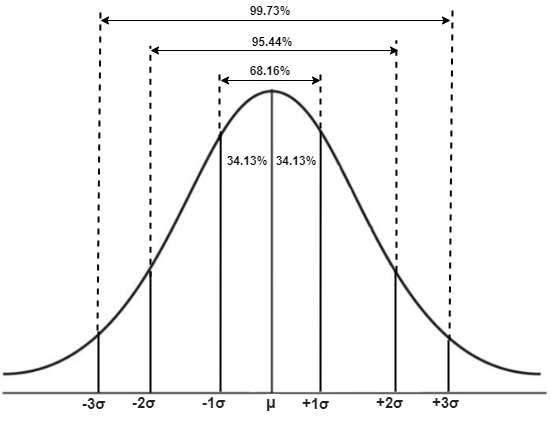

In [316]:
# helper function, check z scores
def check_z_score(z_exclude=3):
    z_scores = {1: 0.6816, 2: 0.9544, 3: 0.9973}
    z_exclude = z_exclude
    low_quartile = round((1 - z_scores[z_exclude]) / 2, 5)
    high_quartile = round(1 - (1 - z_scores[z_exclude]) / 2, 5)

    quartiles = [low_quartile, high_quartile]

    df_B100_range = df_B100_songs.describe().T
    df_10M_range = df_10M.describe(quartiles)['min':'max'].T

    output_df = pd.concat(
        [df_B100_range.rename({'min': 'B100_min', 'max': 'B100_max'}, axis=1), df_10M_range], 
        axis=1)
    
    output_df['low_error'] = output_df['B100_min'] - output_df[df_10M_range.columns[1]]
    output_df['high_error'] = output_df[df_10M_range.columns[3]] - output_df['B100_max']
    
    output_df.loc[['duration_ms', ]] = output_df.loc[['duration_ms', ]] / 60_000  # convert ms to minutes
    output_df = output_df.rename({'duration_ms': 'minutes'})
    
    return output_df[['B100_min', df_10M_range.columns[1], 'low_error', 'B100_max', df_10M_range.columns[3], 'high_error']]



In [317]:
# z-score > 3
z3 = check_z_score(3)

# z-score > 2
z2 = check_z_score(2)

In [318]:
z3

,B100_min,0.1%,low_error,B100_max,99.9%,high_error
acousticness,0.000,0.000,0.000,0.995,0.996,0.001
danceability,0.000,0.000,0.000,0.988,0.950,-0.038
minutes,0.504,0.134,0.370,26.019,25.133,-0.885
energy,0.007,0.001,0.006,0.999,0.999,0.000
instrumentalness,0.000,0.000,0.000,0.985,0.989,0.004
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.012,0.000,0.012,0.999,0.981,-0.018
loudness,-30.346,-40.120,9.774,2.291,-0.814,-3.105
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.000,0.000,0.951,0.960,0.009


In [319]:
z2

,B100_min,2.3%,low_error,B100_max,97.7%,high_error
acousticness,0.000,0.000,-0.000,0.995,0.993,-0.002
danceability,0.000,0.139,-0.139,0.988,0.859,-0.129
minutes,0.504,0.931,-0.428,26.019,8.890,-17.129
energy,0.007,0.027,-0.020,0.999,0.978,-0.021
instrumentalness,0.000,0.000,0.000,0.985,0.948,-0.037
key,0.000,0.000,0.000,11.000,11.000,0.000
liveness,0.012,0.048,-0.035,0.999,0.804,-0.195
loudness,-30.346,-27.796,-2.550,2.291,-3.047,-5.338
mode,0.000,0.000,0.000,1.000,1.000,0.000
speechiness,0.000,0.027,-0.027,0.951,0.506,-0.445


In [320]:
Z_errors = pd.concat([
    z3[[z3.columns[2], z3.columns[5]]].rename({z3.columns[2]: 'Z_error_low_3', z3.columns[5]: 'Z_error_high_3'}, axis=1), 
    z2[[z2.columns[2], z2.columns[5]]].rename({z2.columns[2]: 'Z_error_low_2', z2.columns[5]: 'Z_error_high_2'}, axis=1)], axis=1)
Z_errors

,Z_error_low_3,Z_error_high_3,Z_error_low_2,Z_error_high_2
acousticness,0.000,0.001,-0.000,-0.002
danceability,0.000,-0.038,-0.139,-0.129
minutes,0.370,-0.885,-0.428,-17.129
energy,0.006,0.000,-0.020,-0.021
instrumentalness,0.000,0.004,0.000,-0.037
key,0.000,0.000,0.000,0.000
liveness,0.012,-0.018,-0.035,-0.195
loudness,9.774,-3.105,-2.550,-5.338
mode,0.000,0.000,0.000,0.000
speechiness,0.000,0.009,-0.027,-0.445


In [321]:
df_sqerr = pd.DataFrame()
df_sqerr['Z3'] = Z_errors['Z_error_low_3'] * Z_errors['Z_error_low_3'] + Z_errors['Z_error_high_3'] * Z_errors['Z_error_high_3']
df_sqerr['Z2'] = Z_errors['Z_error_low_2'] * Z_errors['Z_error_low_2'] + Z_errors['Z_error_high_2'] * Z_errors['Z_error_high_2']
df_sqerr['Z3_is_best'] = df_sqerr['Z2'] > df_sqerr['Z3']
df_sqerr

# therefore Zscore of 3 is best for outlier removal

,Z3,Z2,Z3_is_best
acousticness,0.000,0.000,True
danceability,0.001,0.036,True
minutes,0.921,293.597,True
energy,0.000,0.001,True
instrumentalness,0.000,0.001,True
key,0.000,0.000,False
liveness,0.000,0.039,True
loudness,105.170,34.997,False
mode,0.000,0.000,False
speechiness,0.000,0.199,True


In [322]:
z3[[z3.columns[1], z3.columns[4]]]

,0.1%,99.9%
acousticness,0.000,0.996
danceability,0.000,0.950
minutes,0.134,25.133
energy,0.001,0.999
instrumentalness,0.000,0.989
key,0.000,11.000
liveness,0.000,0.981
loudness,-40.120,-0.814
mode,0.000,1.000
speechiness,0.000,0.960


In [323]:
df_B100_songs.describe().T[['min', 'max']]

,min,max
acousticness,0.000,0.995
danceability,0.000,0.988
duration_ms,30213.000,1561133.000
energy,0.007,0.999
instrumentalness,0.000,0.985
key,0.000,11.000
liveness,0.012,0.999
loudness,-30.346,2.291
mode,0.000,1.000
speechiness,0.000,0.951


In [324]:
# longest and shortest songs on B100
df_B100_songs.describe().T[['min', 'max']].rename({'duration_ms': 'minutes'}, axis=1).loc[['duration_ms']] / 60_000

,min,max
duration_ms,0.504,26.019


In [325]:
# yep, actually 26 minutes
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.max()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
17675,7ERSQrRptZVM7q3VOdM7OL,Tubular Bells,Mike Oldfield,album rock,1973-02-01,0.564,0.374,1561133,0.219,0.560,4,0.114,-19.104,0,0.034,103.535,4,0.058


In [326]:
# can't verify this using spotify's search
df_B100_songs[df_B100_songs.duration_ms == df_B100_songs.duration_ms.min()]

,id,song,artist,genre,release_date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
23319,13F8uvVT4s364jof2dn6XU,Fire,Subway,kirtan,2006-01-01,0.197,0.351,30213,0.532,0.110,6,0.443,-29.658,1,0.067,129.338,3,0.227
